# Example: Properties

#### Imports

In [1]:
import numpy as np
import torch
import time
from pathlib import Path
import gc

import dxtb

import logging

logging.getLogger().setLevel(logging.ERROR)

In [2]:
def _tensors_from_gc() -> list:
    return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


def _get_tensor_memory(
    return_number_tensors: bool = False,
) -> float | tuple[float, int]:
    """
    Obtain the total memory occupied by torch.Tensor in the garbage collector.

    Returns
    -------
    tuple[float, int]
        Memory in MiB and number of tensors.
    """

    # obtaining all the tensor objects from the garbage collector
    tensor_objs = _tensors_from_gc()

    # iterate each tensor objects uniquely and calculate the total storage
    visited_data = set()
    total_mem = 0.0
    for tensor in tensor_objs:
        if tensor.is_sparse:
            continue

        # check if it has been visited
        storage = tensor.storage()
        data_ptr = storage.data_ptr()  # type: ignore
        if data_ptr in visited_data:
            continue
        visited_data.add(data_ptr)

        # calculate the storage occupied
        numel = storage.size()
        elmt_size = storage.element_size()
        mem = numel * elmt_size / (1024 * 1024)  # in MiB

        total_mem += mem

    if return_number_tensors is True:
        return total_mem, len(tensor_objs)
    return total_mem

#### dxtb calculation

In [3]:
f = Path(globals()['_dh'][0]) / "molecules" / "nylon.xyz"
atoms, xyz = dxtb.io.read_structure_from_file(f)

In [4]:
device = torch.device("cpu")
dd: dxtb._types.DD = {"device": device, "dtype": torch.double}

# numbers = torch.tensor(atoms, device=device)
# positions = torch.tensor(xyz, **dd)
GFN1_XTB = dxtb.GFN1_XTB

n = 5000
numbers = torch.randint(1, 86, (n,), device=device)
positions = torch.rand((n, 3), **dd) * 10

ihelp = dxtb.IndexHelper.from_numbers(
    numbers, dxtb.param.get_elem_angular(GFN1_XTB.element)
)

### Autograd utils

In [5]:
repeats = 10

times = {}


def nth_derivative(f, wrt, n=1):
    if n == 0:
        return

    create_graph = False if n == 1 else True

    for _ in range(n):
        (grads,) = torch.autograd.grad(f, wrt, create_graph=create_graph)
        f = grads.sum()

    return grads  # type: ignore


def print_average(times):
    print()
    if repeats > 1:
        avg_time = sum(times) / len(times)
        print(f"Average ({repeats}): {avg_time:2.4f} sec")
        return avg_time


def time_operation(operation, pos, n):
    times = []
    for _ in range(repeats):
        gc.collect()
        _pos = pos.detach().clone().requires_grad_(True)

        ts = time.perf_counter()

        s = operation(_pos).sum()  # Execute the operation passed as an argument

        size, num = _get_tensor_memory(return_number_tensors=True)
        ds = nth_derivative(s, _pos, n=n)
        size0, num0 = _get_tensor_memory(return_number_tensors=True)

        te = time.perf_counter()
        times.append(te - ts)

        print(f"{size - size0:.16f} MiB of {num-num0:d} addtional tensors {size0}")

        gc.collect()
        print(f"{te - ts:2.4f}", end=" ")

    avg_time = print_average(times)
    return avg_time

# Analytical

In [6]:
ihelp = dxtb.IndexHelper.from_numbers(
    numbers, dxtb.param.get_elem_angular(GFN1_XTB.element)
)

rep = dxtb.new_repulsion(numbers, GFN1_XTB)
assert rep is not None
cache = rep.get_cache(numbers, ihelp)

t1 = {}

### Energy

In [7]:
n = 0
t1[n] = time_operation(lambda pos: rep.get_energy(pos, cache), positions, n)

/opt/miniforge3/envs/dxtb/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:347: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(
/tmp/ipykernel_350569/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]
/tmp/ipykernel_350569/1953877020.py:28: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = tensor.storage()


0.0000000000000000 MiB of 0 addtional tensors 1384.3114376068115
2.5455 0.0000000000000000 MiB of 0 addtional tensors 1384.3114376068115
2.5860 0.0000000000000000 MiB of 0 addtional tensors 1384.3114376068115
2.5911 0.0000000000000000 MiB of 0 addtional tensors 1384.3114376068115
2.5566 0.0000000000000000 MiB of 0 addtional tensors 1384.3114376068115
2.6137 0.0000000000000000 MiB of 0 addtional tensors 1384.3114376068115
2.4975 0.0000000000000000 MiB of 0 addtional tensors 1384.3114376068115
2.5766 0.0000000000000000 MiB of 0 addtional tensors 1384.3114376068115
2.6126 0.0000000000000000 MiB of 0 addtional tensors 1384.3114376068115
2.7038 0.0000000000000000 MiB of 0 addtional tensors 1384.3114376068115
2.6109 
Average (10): 2.5894 sec


### 1st Derivative

In [8]:
n = 1
t1[n] = time_operation(lambda pos: rep.get_energy(pos, cache), positions, n)

/tmp/ipykernel_350569/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


1072.7691726684570312 MiB of 7 addtional tensors 311.5422649383545
7.2230 1072.8836135864257812 MiB of 8 addtional tensors 311.5422649383545
6.9275 1072.8836135864257812 MiB of 8 addtional tensors 311.5422649383545
7.0349 1072.8836135864257812 MiB of 8 addtional tensors 311.5422649383545
6.8251 1072.8836135864257812 MiB of 8 addtional tensors 311.5422649383545
6.7349 1072.8836135864257812 MiB of 8 addtional tensors 311.5422649383545
6.7905 1072.8836135864257812 MiB of 8 addtional tensors 311.5422649383545
6.8388 1072.8836135864257812 MiB of 8 addtional tensors 311.5422649383545
6.5078 1072.8836135864257812 MiB of 8 addtional tensors 311.5422649383545
6.9021 1072.8836135864257812 MiB of 8 addtional tensors 311.5422649383545
6.9169 
Average (10): 6.8702 sec


### 2nd Derivative

In [9]:
n = 2
t1[n] = time_operation(lambda pos: rep.get_energy(pos, cache), positions, n)

/tmp/ipykernel_350569/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


-953.7887649536132812 MiB of -8 addtional tensors 2338.100202560425
17.8824 1072.9980545043945312 MiB of 9 addtional tensors 2338.100202560425
18.5980 1072.9980545043945312 MiB of 9 addtional tensors 2338.100202560425
18.2706 1072.9980545043945312 MiB of 9 addtional tensors 2338.100202560425
17.6001 1072.9980545043945312 MiB of 9 addtional tensors 2338.100202560425
17.3859 1072.9980545043945312 MiB of 9 addtional tensors 2338.100202560425
17.8238 1072.9980545043945312 MiB of 9 addtional tensors 2338.100202560425
18.8032 1072.9980545043945312 MiB of 9 addtional tensors 2338.100202560425
18.3056 1072.9980545043945312 MiB of 9 addtional tensors 2338.100202560425
18.9808 1072.9980545043945312 MiB of 9 addtional tensors 2338.100202560425
18.2279 
Average (10): 18.1878 sec


### 3rd Derivative

In [10]:
n = 3
t1[n] = time_operation(lambda pos: rep.get_energy(pos, cache), positions, n)

/tmp/ipykernel_350569/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


-953.7887725830078125 MiB of -9 addtional tensors 2338.1002101898193
42.3491 1072.9980545043945312 MiB of 9 addtional tensors 2338.1002101898193
41.3184 1072.9980545043945312 MiB of 9 addtional tensors 2338.1002101898193
42.7351 1072.9980545043945312 MiB of 9 addtional tensors 2338.1002101898193
42.1697 1072.9980545043945312 MiB of 9 addtional tensors 2338.1002101898193
42.8038 1072.9980545043945312 MiB of 9 addtional tensors 2338.1002101898193
41.4053 1072.9980545043945312 MiB of 9 addtional tensors 2338.1002101898193
40.5897 1072.9980545043945312 MiB of 9 addtional tensors 2338.1002101898193
40.1696 1072.9980545043945312 MiB of 9 addtional tensors 2338.1002101898193
41.6473 1072.9980545043945312 MiB of 9 addtional tensors 2338.1002101898193
40.1669 
Average (10): 41.5355 sec


### 4th Derivative

In [11]:
n = 4
# t1[n] = time_operation(lambda pos: rep.get_energy(pos, cache), positions, n)

# Full Autograd

In [12]:
ihelp = dxtb.IndexHelper.from_numbers(
    numbers, dxtb.param.get_elem_angular(GFN1_XTB.element)
)

rep = dxtb.new_repulsion(numbers, GFN1_XTB)
assert rep is not None
cache = rep.get_cache(numbers, ihelp)

def eval(pos, c):
    e = dxtb.classical.repulsion.repulsion_energy(
        pos, c.mask, c.arep, c.kexp, c.zeff
    )
    return 0.5 * torch.sum(e, dim=-1)

t2 = {}

### Energy

In [13]:
n = 0
t2[n] = time_operation(lambda pos: eval(pos, cache), positions, n)

/tmp/ipykernel_350569/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


0.0000000000000000 MiB of 0 addtional tensors 1193.5765743255615
2.5478 0.0000000000000000 MiB of 0 addtional tensors 1193.5765743255615
2.5625 0.0000000000000000 MiB of 0 addtional tensors 1193.5765743255615
2.6166 0.0000000000000000 MiB of 0 addtional tensors 1193.5765743255615
2.5198 0.0000000000000000 MiB of 0 addtional tensors 1193.5765743255615
2.4453 0.0000000000000000 MiB of 0 addtional tensors 1193.5765743255615
2.3755 0.0000000000000000 MiB of 0 addtional tensors 1193.5765743255615
2.4296 0.0000000000000000 MiB of 0 addtional tensors 1193.5765743255615
2.3837 0.0000000000000000 MiB of 0 addtional tensors 1193.5765743255615
2.5104 0.0000000000000000 MiB of 0 addtional tensors 1193.5765743255615
2.5258 
Average (10): 2.4917 sec


### 1st Derivative

In [14]:
positions = positions.detach().clone().requires_grad_(True)
n = 1
t2[n] = time_operation(lambda pos: eval(pos, cache), positions, n)

/tmp/ipykernel_350569/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


882.0343093872070312 MiB of 6 addtional tensors 311.5422649383545
5.8562 882.1487503051757812 MiB of 7 addtional tensors 311.5422649383545
5.6923 882.1487503051757812 MiB of 7 addtional tensors 311.5422649383545
5.5038 882.1487503051757812 MiB of 7 addtional tensors 311.5422649383545
5.6318 882.1487503051757812 MiB of 7 addtional tensors 311.5422649383545
5.5217 882.1487503051757812 MiB of 7 addtional tensors 311.5422649383545
5.4605 882.1487503051757812 MiB of 7 addtional tensors 311.5422649383545
5.7662 882.1487503051757812 MiB of 7 addtional tensors 311.5422649383545
5.7820 882.1487503051757812 MiB of 7 addtional tensors 311.5422649383545
5.5502 882.1487503051757812 MiB of 7 addtional tensors 311.5422649383545
5.5083 
Average (10): 5.6273 sec


### 2nd Derivative

In [15]:
positions = positions.detach().clone().requires_grad_(True)
n = 2
t2[n] = time_operation(lambda pos: eval(pos, cache), positions, n)

/tmp/ipykernel_350569/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


-0.1144485473632812 MiB of -2 addtional tensors 1193.6910228729248
13.2221 858.4213333129882812 MiB of 7 addtional tensors 1193.6910228729248
13.7828 858.4213333129882812 MiB of 7 addtional tensors 1193.6910228729248
13.8222 858.4213333129882812 MiB of 7 addtional tensors 1193.6910228729248
13.5092 858.4213333129882812 MiB of 7 addtional tensors 1193.6910228729248
13.9113 858.4213333129882812 MiB of 7 addtional tensors 1193.6910228729248
13.5120 858.4213333129882812 MiB of 7 addtional tensors 1193.6910228729248
13.6759 858.4213333129882812 MiB of 7 addtional tensors 1193.6910228729248
13.2390 858.4213333129882812 MiB of 7 addtional tensors 1193.6910228729248
13.5374 858.4213333129882812 MiB of 7 addtional tensors 1193.6910228729248
13.4515 
Average (10): 13.5663 sec


### 3rd Derivative

In [16]:
positions = positions.detach().clone().requires_grad_(True)
n = 3
t2[n] = time_operation(lambda pos: eval(pos, cache), positions, n)

/tmp/ipykernel_350569/1953877020.py:2: PydanticDeprecatedSince20: `pydantic.config.Extra` is deprecated, use literal values instead (e.g. `extra='allow'`). Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.0.3/migration/
  return [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor)]


-0.1144561767578125 MiB of -3 addtional tensors 1193.6910305023193
37.7197 858.4213333129882812 MiB of 7 addtional tensors 1193.6910305023193
39.3926 858.4213333129882812 MiB of 7 addtional tensors 1193.6910305023193
38.9420 858.4213333129882812 MiB of 7 addtional tensors 1193.6910305023193
38.7380 858.4213333129882812 MiB of 7 addtional tensors 1193.6910305023193
38.6520 858.4213333129882812 MiB of 7 addtional tensors 1193.6910305023193
38.8614 858.4213333129882812 MiB of 7 addtional tensors 1193.6910305023193
36.9119 858.4213333129882812 MiB of 7 addtional tensors 1193.6910305023193
37.2543 858.4213333129882812 MiB of 7 addtional tensors 1193.6910305023193
38.4290 858.4213333129882812 MiB of 7 addtional tensors 1193.6910305023193
37.9721 
Average (10): 38.2873 sec


### 4th Derivative

In [17]:
# positions = positions.detach().clone().requires_grad_(True)
# n = 4
# t2[n] = time_operation(lambda pos: eval(pos, cache), positions, n)

# Analyze

In [18]:
import matplotlib.pyplot as plt

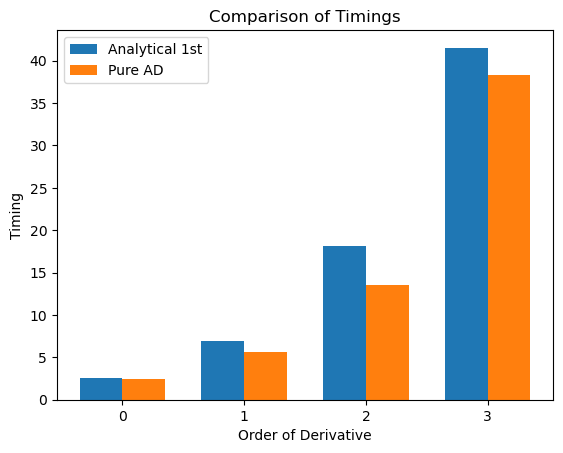

In [19]:
n_values = list(t1.keys())
t1_timings = [t1[n] for n in n_values]
t2_timings = [t2[n] for n in n_values]

# Setting up the x-axis positions for the bars
bar_width = 0.35
index = np.arange(len(n_values))

# Plotting the bars
fig, ax = plt.subplots()
bar1 = ax.bar(index, t1_timings, bar_width, label='Analytical 1st')
bar2 = ax.bar(index + bar_width, t2_timings, bar_width, label='Pure AD')

# Adding labels and title
ax.set_xlabel('Order of Derivative')
ax.set_ylabel('Timing')
ax.set_title('Comparison of Timings')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(n_values)
ax.legend()

# Show the plot
plt.show()
